# Benchmarking Raspberry Pi + Intel Movidius using Inception v4

# Environment setup
To measure the current consumption I measured the voltage drop in a resistor.
* The resistor was supposed to be 1 Ohm ± 1% ([RS0051R000FE12](https://www.mouser.es/productdetail/vishay-dale/rs0051r000fe12?qs=%252b%2f1MMOhkBTf5JUBsk0YDOg==)), but when measuring with the multimiter it turned out to be 1.6 Ohms.
* The 10x attenuator was enabled in the oscilloscope probes but not on the scope. This means that to obtain the real voltages, the data has to be multiplied by ten.
* The voltage input was actually not 5V. It was a bit higher to feed the Raspberry Pi with a value closer to 5V when the current consumption increased.
* The static current consumption of the setup before starting the inference (i.e. before executing `make VERSION=V4 infer`) was between 200 and 300 mA. This is the power drained by Raspberry Pi B+ v1.2 running clean Raspbian (with the Movidius tools installed), connected through Ethernet.

![Setup](../setup.png)

## Screenshot from the oscilloscope
This screenshot shows the entire duration of the command `make VERSION=v1 infer`. The data that we will be using from the CSV corresponds to the second peak and each peak corresponds to one inference. Since the first one initialises some data structures that will be reused in the upcoming inferences, we discard it because usually we would not be performing a single analysis. 

![2x inferences](2x_inferences.png)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

## Output (accuracy and latency)

In [2]:
! cat output.txt

pi@raspberrypi:~/oscw18-edge-ai/movidius $ make VERSION=v4 infer INPUT=data/pic_002.jpg 

Running inferences on data/pic_002.jpg...
(python3 image-classifier.py --graph ./model/v4/inception_v4_ncgraph --dim 299 299 --mean 127.5 --scale 0.00789 --colormode "RGB" --labels ./model/v4/labels.txt --image data/pic_002.jpg)

Top predictions for pic_002.jpg
Execution time: 635.782ms
--------------------------------------------------------------
91.4%   288:lynx, catamount
0.8%    282:tabby, tabby cat
0.3%    283:tiger cat
0.2%    284:Persian cat
0.2%    286:Egyptian cat


In [3]:
latency = 635.782

## Parse raw data 

In [4]:
df_params = pd.read_csv("second_inference.csv", nrows=1, usecols=['Start', 'Increment'])
period_ms = df_params['Increment'][0] * 1000
period_ms

1.0

In [5]:
df_val = pd.read_csv("second_inference.csv", skiprows=[1], usecols=['X', 'CH1', 'CH2'])
df_val.loc[:, 'X'] *= period_ms

# probes were in 10x scale, scope in 1x
df_val.loc[:, 'CH1'] *= 10
df_val.loc[:, 'CH2'] *= 10

df_val.rename(index=str, columns={'X': 'time [ms]', 'CH1': 'vout [V]', 'CH2': 'vin [V]'}, inplace=True)
df_val[:10]

,time [ms],vout [V],vin [V]
0,0.0,4.39,5.22
1,1.0,4.72,5.29
2,2.0,4.45,5.23
3,3.0,4.65,5.28
4,4.0,4.45,5.28
5,5.0,4.65,5.23
6,6.0,4.74,5.29
7,7.0,4.41,5.22
8,8.0,4.67,5.28
9,9.0,4.34,5.21


# Obtaining power consumption

In [6]:
R = 1.6 # ohm
static_curr = 200 # [mA] lowest value to avoid having negative power consumptions
df_val['total curr [mA]'] = (df_val['vin [V]'] - df_val['vout [V]']) * 1000 / R
df_val['curr [mA]'] = (df_val['vin [V]'] - df_val['vout [V]']) * 1000 / R - static_curr

df_val['total pow [mW]'] = df_val['total curr [mA]'] * df_val['vout [V]']
df_val['pow [mW]'] = df_val['curr [mA]'] * df_val['vout [V]']
df_val[:10]

,time [ms],vout [V],vin [V],total curr [mA],curr [mA],total pow [mW],pow [mW]
0,0.0,4.39,5.22,518.75,318.75,2277.3125,1399.3125
1,1.0,4.72,5.29,356.25,156.25,1681.5000,737.5000
2,2.0,4.45,5.23,487.50,287.50,2169.3750,1279.3750
3,3.0,4.65,5.28,393.75,193.75,1830.9375,900.9375
4,4.0,4.45,5.28,518.75,318.75,2308.4375,1418.4375
5,5.0,4.65,5.23,362.50,162.50,1685.6250,755.6250
6,6.0,4.74,5.29,343.75,143.75,1629.3750,681.3750
7,7.0,4.41,5.22,506.25,306.25,2232.5625,1350.5625
8,8.0,4.67,5.28,381.25,181.25,1780.4375,846.4375
9,9.0,4.34,5.21,543.75,343.75,2359.8750,1491.8750


Text(0.5,1,'Power')

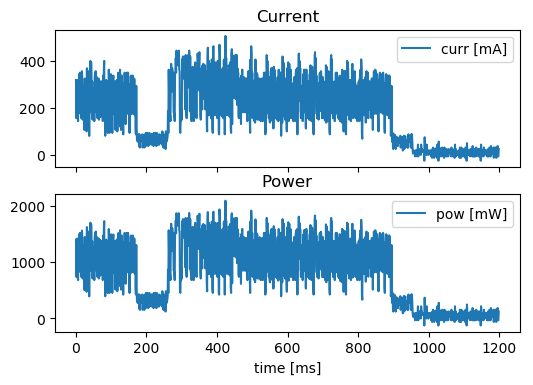

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, dpi=100)

df_val.plot(ax=ax1, x='time [ms]', y='curr [mA]')
ax1.set_title("Current")
df_val.plot(ax=ax2, x='time [ms]', y='pow [mW]')
ax2.set_title("Power")

## Manually selecting when inference happens

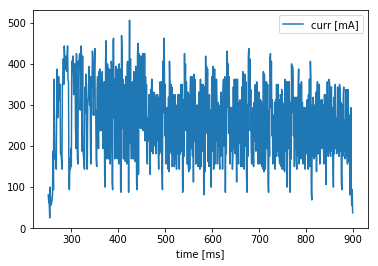

In [8]:
df_val = df_val.loc[df_val['time [ms]'] > 250]
df_val = df_val.loc[df_val['time [ms]'] < 900]

df_val.plot(x='time [ms]', y='curr [mA]')

## Obtaining total energy consumption

In [9]:
energy = df_val['curr [mA]'].sum() * period_ms # mA*ms
energy /= (1000 * 3600) # mAh

energy_tot = df_val['total curr [mA]'].sum() * period_ms # mA*ms
energy_tot /= (1000 * 3600) # mAh

max_power = max(df_val['pow [mW]'])
max_power_tot = max(df_val['total pow [mW]'])

print("Energy consumed during 1 inference:  %f mAh" % energy)
print("Total energy consumed during 1 inference: %f mAh " % energy_tot)
print("Peak power consumption %f mW" % max_power)
print("Total peak power consumption %f mW" % max_power_tot)

Energy consumed during 1 inference:  0.047457 mAh
Total energy consumed during 1 inference: 0.083512 mAh 
Peak power consumption 2090.812500 mW
Total peak power consumption 2916.812500 mW


## Battery analysis

In [10]:
fps_max = 1/(latency/1000.0)
print('Max FPS = %f' % fps_max)

Max FPS = 1.572866


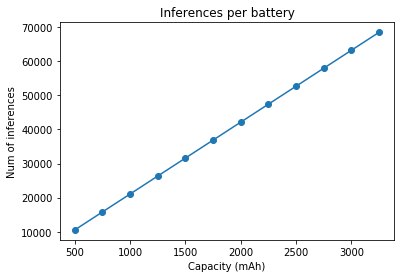

In [11]:
cap = range(500, 3500, 250) # Ranges of battery capacities we're interested on
inf_num = (cap / energy)
plt.title('Inferences per battery')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Num of inferences')
plt.plot(cap, inf_num, marker='o')

In [12]:
print('With 500 mAh, %i inferences can be done' % inf_num[cap.index(500)])
print('With 1000 mAh, %i inferences can be done' % inf_num[cap.index(1000)])
print('With 1500 mAh, %i inferences can be done' % inf_num[cap.index(1500)])

With 500 mAh, 10535 inferences can be done
With 1000 mAh, 21071 inferences can be done
With 1500 mAh, 31607 inferences can be done


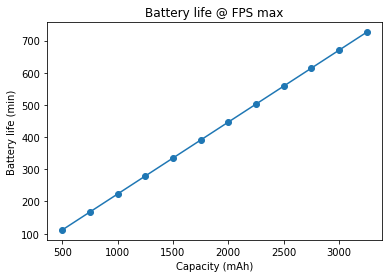

In [13]:
plt.title('Battery life @ FPS max')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Battery life (min)')
batt_life = inf_num/(fps_max * 60)
plt.plot(cap, batt_life, marker='o')

In [14]:
print('A 500 mAh battery lasts %i min' % batt_life[cap.index(500)])
print('A 1000 mAh battery lasts %i min' % batt_life[cap.index(1000)])
print('A 1500 mAh battery lasts %i min' % batt_life[cap.index(1500)])

A 500 mAh battery lasts 111 min
A 1000 mAh battery lasts 223 min
A 1500 mAh battery lasts 334 min
